# Dataset and Dataloader

In [10]:
import numpy as np
import pandas as pd
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import *
import tqdm
import matplotlib.pyplot as plt

In [11]:
class CancerDataset(Dataset):
    
    # constructor
    def __init__(self, df_X, df_y):
        assert len(df_X) == len(df_y)
        
        self.data_list = torch.FloatTensor(df_X.values)
        self.target_list = torch.LongTensor(df_y.values)
        
        assert(len(self.data_list) == len(self.target_list))
      
    # return the length of dataset
    def __len__(self):
        return len(self.data_list)
    
    # return the key-th element of dataset
    def __getitem__(self, key):
        
        return self.data_list[key], self.target_list[key]
    

In [12]:
class CancerPredictor(nn.Module):
    
    # constructor
    def __init__(self, input_size, hidden_size, n_class):
        super().__init__()
        
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.input_relu = nn.ReLU()
        self.hidden_linear = nn.Linear(hidden_size, n_class)
        
        # do not use in forward, but use in predict
        self.soft_max = nn.Softmax(dim=-1)

    
    def forward(self, inputs):
        out = None
        out = self.input_layer(inputs)
        out = self.input_relu(out)
        out = self.hidden_linear(out)
        
        ## We do not compute soft max directly
        ## But combine it with loss. Because F.cross_entropy 
        ## Will compute soft max
        # out = self.soft_max(out)
        
        return out
    
    def predict_prob(self, inputs):
        """
        call self.forward, then calculate softmax to get the probability
        """
        out = self.forward(inputs)
        out = self.soft_max(out)
        
        return out
        
    def predict(self, inputs):
        """
        hard predict, call predict_prob, then get the max index
        """
        out = self.predict_prob(inputs)
        pred = torch.argmax(out, dim=1)
        
        return pred


In [13]:
class Learner():
    # constructor
    def __init__(self,  model, criterion, optimizer):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
       
        
    def train(self, train_loader, valid_loader, device, num_epochs, early_stop_patience=5, print_log=True):
        self.early_stop_patience = early_stop_patience
        no_improve = 0
        
        train_loss_history = []
        valid_loss_history = []
        
        min_loss = np.Infinity
        for epoch in tqdm.notebook.tqdm(range(num_epochs)):
            
            train_loss_epoch = []
            valid_loss_epoch = []
            
            self.model.train()

            for i, (data_batch, target_batch) in enumerate(train_loader):
                preds = self.model(data_batch.to(device))
                train_loss = self.criterion(preds, target_batch.to(device))
                train_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss_epoch.append(train_loss.item())
            
            batch_min_loss = np.Infinity
            self.model.eval()
            for i, (data_batch, target_batch) in enumerate(valid_loader):
                preds = self.model(data_batch.to(device))
                valid_loss = criterion(preds, target_batch.to(device))
                optimizer.zero_grad()
                valid_loss_epoch.append(valid_loss.item())
                    
                if valid_loss < batch_min_loss:
                    batch_min_loss = valid_loss
            
            mean_train_loss_epoch = np.mean(train_loss_epoch)
            mean_valid_loss_epoch = np.mean(valid_loss_epoch)
            
            train_loss_history.append(mean_train_loss_epoch)
            valid_loss_history.append(mean_valid_loss_epoch)
            
            if batch_min_loss < min_loss:
                no_improve = 0
                min_loss = batch_min_loss
                torch.save(model, 'best_model.pt')
            else:
                no_improve += 1
                if no_improve > self.early_stop_patience:
                    print(f"Early Stop at epoch {epoch}")
                    break
                
            if print_log:
                print(f"Epoch: {epoch}, train_loss: {mean_train_loss_epoch},\
                        valid_loss: {mean_valid_loss_epoch}")
        
        return train_loss_history, valid_loss_history
    
    def do_test(self, test_loader, device, best_model=None):
        if best_model == None:
            best_model = self.model
            
        real_data = []
        pred_data = []
        best_model.eval()
        
        for i, (data_batch, target_batch) in enumerate(test_loader):
            preds = best_model.predict(data_batch.to(device))
            # test_loss = self.criterion(preds, target_batch.to(device))
            optimizer.zero_grad()

            for i in range(len(target_batch)):
                
                real_data.append(target_batch[i].item())
                pred_data.append(preds[i].item())
        
        return np.array(real_data), np.array(pred_data)

In [14]:
df = pd.read_csv('train_ml2_2021.csv')
X = df.drop(columns=['target', 'problem_id'])
y = df.target

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

In [16]:
def make_weights(dataset):
    X = dataset.data_list
    Y = dataset.target_list
    nclasses = Y.unique(return_counts=True)[1] / Y.shape[0]
    
    return torch.DoubleTensor([nclasses[y] for y in Y])

train_dataset = CancerDataset(X_train, y_train)
valid_dataset = CancerDataset(X_val, y_val)
weights = make_weights(train_dataset)
sampler = WeightedRandomSampler(weights, len(weights))                     

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [17]:
n, input_size = X.shape
hidden_size = 8
n_class = len(y.unique())

In [18]:
model = CancerPredictor(input_size, hidden_size, n_class)

In [19]:
lr = 0.001
nb_epoch = 50
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda: 5")
else:
    device = torch.device("cpu")

In [21]:
learner = Learner(model, criterion, optimizer)

In [22]:
train_log, valid_log = learner.train(train_loader, valid_loader, device, nb_epoch, early_stop_patience=10, \
                                    print_log=False)

Early Stop at epoch 19



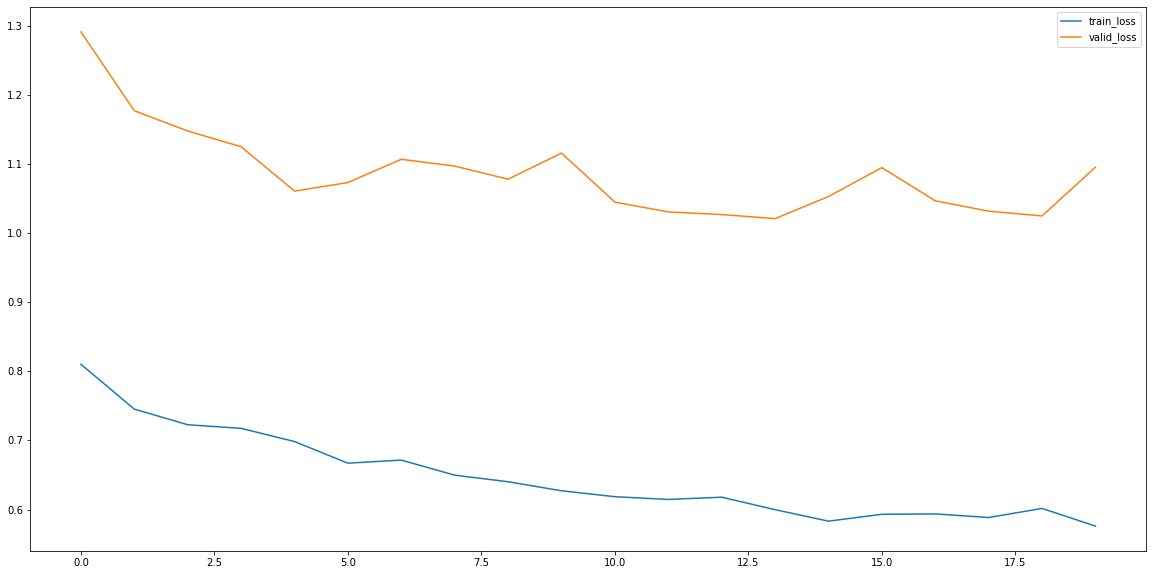

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(train_log, label="train_loss")
ax.plot(valid_log, label="valid_loss")
ax.legend()
plt.show()

In [24]:
best_model = torch.load("best_model.pt")

In [25]:
real_data, pred_data = learner.do_test(train_loader, device, best_model=best_model)

In [26]:
accuracy = (real_data == pred_data).sum() / len(real_data)

In [27]:
accuracy

0.7059177834663455